In [125]:
from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import numpy as np
from matplotlib.patches import Rectangle
from random import random
from matplotlib.lines import Line2D

%matplotlib inline


In [111]:
iran = {'north': 31, 'south': 26, 'west': 59, 'east': 64}
india = {'north': 24, 'south': 19, 'west': 80, 'east': 85}

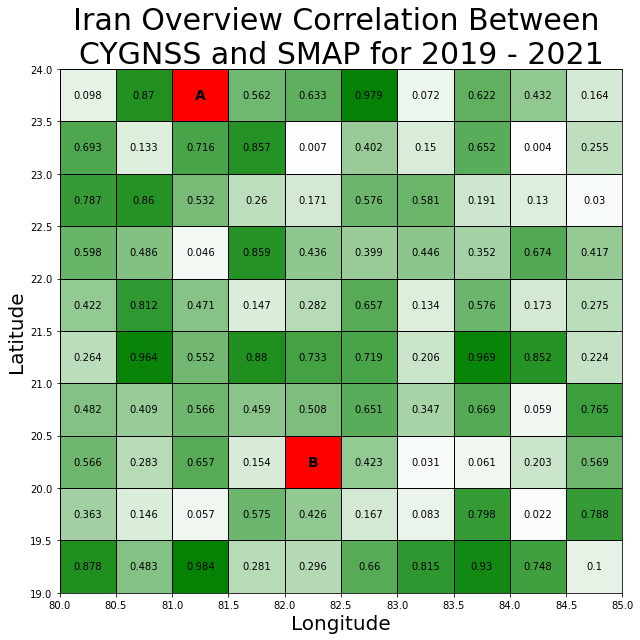

In [113]:
selected_area_string = 'Iran'
selected_area = india
alphabet = ['A', 'B', 'C', 'D', 'E', 'F']
special_regions = [(81.0, 23.5), (82.0, 20.0)]

fig, ax = plt.subplots(figsize=(9, 9))

plt.xlim([selected_area['west'], selected_area['east']])
plt.ylim([selected_area['south'], selected_area['north']])


ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))

index = 0
for x in np.arange(selected_area['west'], selected_area['east'] - 0.05, 0.5):
    for y in np.arange(selected_area['south'], selected_area['north'] - 0.05, 0.5):
        if (x, y) not in special_regions:
            current_corr = round(random(), 3)
            ax.text(x + 0.25, y + 0.25, current_corr, fontsize=10, verticalalignment='center', horizontalalignment='center')
            ax.add_patch(Rectangle((x, y), 0.5, 0.5, color='green', alpha=current_corr))
        else:
            ax.text(x + 0.25, y + 0.25, alphabet[index], fontsize=14, verticalalignment='center', horizontalalignment='center', weight='bold')
            ax.add_patch(Rectangle((x, y), 0.5, 0.5, color='red'))
            index = index + 1
            
                
plt.title(selected_area_string + ' Overview Correlation Between \nCYGNSS and SMAP for 2019 - 2021', fontsize=30)

ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)

plt.tight_layout()

plt.grid(color='black', linewidth=1)
plt.show()

# Each square represents a 0.5 by 0.5 degrees area
# The darker the green color, the higher the corelation between CYGNSS and SMAP
# The complete time series will be shown for the red squares



In [101]:
import pandas as pd
from time import time
import numpy as np
from tqdm import tqdm
import os
import netCDF4 as nc
from progressbar import progressbar
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
import datetime
from matplotlib import pyplot as plt, rcParams
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib
from scipy.ndimage import gaussian_filter
from scipy.interpolate import LinearNDInterpolator
from regions import RectanglePixelRegion, PixCoord


def universal_plot(df, target_value='swvl1', title=None, bar_title=None, vmin=None, vmax=None, 
                   save=None, dot_size=0.5, std=False, fig_size=None, regions=None):
    
    if fig_size is not None:
        plt.rcParams["figure.figsize"] = fig_size
    else:
        plt.rcParams["figure.figsize"] = (8,8)
    
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    lat_list, long_list = get_plot_ticks(df['lat'], df['long'])
    ax.set_xticks(long_list, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_list, crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    
    if std:
        cmap = 'Greys'
    else:
        cmap = 'Spectral'
        
    if vmin is not None:
        plt.scatter(df['long'], df['lat'], c=list(df[target_value]), s=dot_size, cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        plt.scatter(df['long'], df['lat'], c=list(df[target_value]), s=dot_size, cmap=cmap)
    
    bar = plt.colorbar(shrink=0.8)
    if bar_title is not None:
        bar.ax.set_title(bar_title)
    
    if title is not None:
        plt.title(title, fontsize=20, fontweight='book')
    
    if regions is not None:
        
        regions[0].plot(ax=ax, color='black', lw=2.0)
        ax.annotate('Uniform soil', (regions[0].center.x + regions[0].width/2 + 0.2, regions[0].center.y),
                       fontsize=22,
                       color='black')
        regions[1].plot(ax=ax, color='blue', lw=2.0)
        ax.annotate('Variable soil', (regions[1].center.x, regions[1].center.y - regions[1].height/2 - 0.7),
                    fontsize=22,
                    color='blue',
                    horizontalalignment='center')
        
    plt.xlabel('Longitude', fontsize=16)
    plt.ylabel('Latitude', fontsize=16)
    
    if save is not None:
        plt.savefig(save, bbox_inches='tight')

    plt.show()
    

def filter_cygnss_df(df: pd.DataFrame, area: dict) -> pd.DataFrame:
    if 'sp_lat' in df.columns:
        new_df = df[df['sp_lat'] <= area['north']]
        new_df = new_df[new_df['sp_lat'] >= area['south']]
        new_df = new_df[new_df['sp_lon'] >= area['west']]
        new_df = new_df[new_df['sp_lon'] <= area['east']]
    else:
        new_df = df[df['lat'] <= area['north']]
        new_df = new_df[new_df['lat'] >= area['south']]
        new_df = new_df[new_df['long'] >= area['west']]
        new_df = new_df[new_df['long'] <= area['east']]

    return new_df


def filter_cygnss_day(df, start_day, end_day):
    filtered_df = df[df['day_of_year'] >= start_day]
    filtered_df = filtered_df[filtered_df['day_of_year'] < end_day]
    
    return filtered_df


def get_plot_ticks(lat_values, long_values):
    min_lat = min(lat_values)
    max_lat = max(lat_values)
    min_long = min(long_values)
    max_long = max(long_values)
    
    lat_step_size = (max_lat - min_lat) / 3
    long_step_size = (max_long - min_long) / 3
    
    long_list = [min_long, min_long + long_step_size, min_long + 2 * long_step_size, max_long]
    lat_list = [min_lat, min_lat + lat_step_size, min_lat + 2 * lat_step_size, max_lat]
    
    # Rounding to two decimals
    long_list = [round(num, 2) for num in long_list]
    lat_list = [round(num, 2) for num in lat_list]
    
    return lat_list, long_list


def grid_box(df, target_value='sr', use_median=True):
    df['lat'] = df['lat'].apply(lambda x: round(x, 1))
    df['long'] = df['long'].apply(lambda x: round(x, 1))
    
    if use_median:
        df = df.groupby(['long', 'lat'], as_index=False)[target_value].median()
    else:
        df = df.groupby(['long', 'lat'], as_index=False)[target_value].mean()
    
    return df


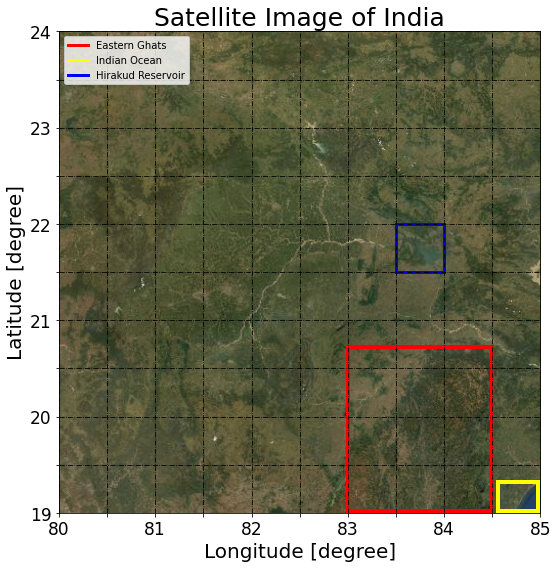

In [257]:
plt.rcParams["figure.autolayout"] = True
im = plt.imread("/Users/vegardhaneberg/Desktop/Time Series/India/Areal India.png")
fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(im, extent=[80, 85, 19, 24])
plt.title('Satellite Image of India', fontsize=25)

# Hilly Area
ax.add_patch(Rectangle((83, 19.02), 1.5, 1.7, lw=4, fill=False, edgecolor='red'))

# Water Area
ax.add_patch(Rectangle((84.56, 19.02), 0.42, 0.3, lw=4, fill=False, edgecolor='yellow'))

# Lake Area
ax.add_patch(Rectangle((83.5, 21.5), 0.5, 0.5, lw=3, fill=False, edgecolor='blue'))

# Legend
legend_elements = [Line2D([0], [0], color='red', lw=3, label='Eastern Ghats'),
                   Line2D([0], [0], color='yellow', lw=3, label='Indian Ocean'),
                   Line2D([0], [0], color='blue', lw=3, label='Hirakud Reservoir')]
ax.legend(handles=legend_elements, loc='upper left')

plt.xlabel('Longitude [degree]', fontsize=20)
plt.ylabel('Latitude [degree]', fontsize=20)

ax.xaxis.set_ticks([80, 81, 82, 83, 84, 85])
ax.set_xticklabels(['80', '81', '82', '83', '84', '85'], fontsize=17)
ax.yaxis.set_ticks([19, 20, 21, 22, 23, 24])
ax.set_yticklabels(['19', '20', '21', '22', '23', '24'], fontsize=17)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.grid(color='black', ls='-.')

plt.savefig('/Users/vegardhaneberg/Desktop/Time Series/India/Areal India Plot')
plt.show()

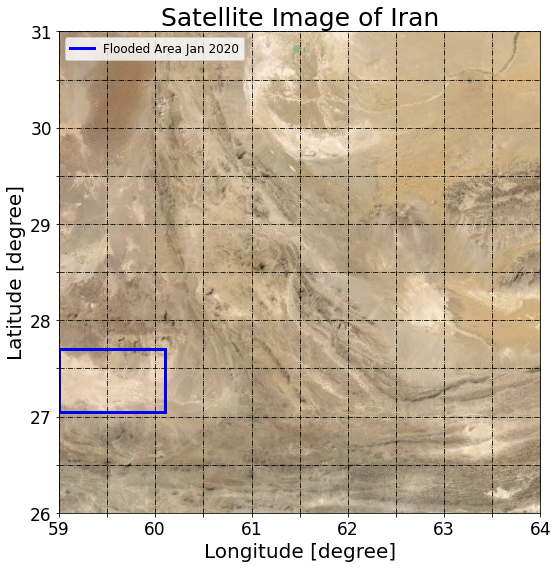

In [258]:
plt.rcParams["figure.autolayout"] = True
im = plt.imread("/Users/vegardhaneberg/Desktop/Time Series/Iran/Iran Areal.png")
fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(im, extent=[59, 64, 26, 31])

plt.title('Satellite Image of Iran', fontsize=25)
plt.xlabel('Longitude [degree]', fontsize=20)
plt.ylabel('Latitude [degree]', fontsize=20)

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

ax.xaxis.set_ticks([59, 60, 61, 62, 63, 64])
ax.set_xticklabels(['59', '60', '61', '62', '63', '64'], fontsize=17)
ax.yaxis.set_ticks([26, 27, 28, 29, 30, 31])
ax.set_yticklabels(['26', '27', '28', '29', '30', '31'], fontsize=17)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))

# plt.yticks([26, 27, 28, 29, 30, 31], fontsize=20)
# plt.xticks([59, 60, 61, 62, 63, 64], fontsize=20)
# plt.yticks([26, 26.5, 27, 27.5, 28, 28.5, 29, 29.5, 30, 30.5, 31], fontsize=20)
# plt.xticks([59, 59.5, 60, 60.5, 61, 61.5, 62, 62.5, 63, 63.5, 64], fontsize=20)


# Flood Area
ax.add_patch(Rectangle((59, 27.05), 1.1, 0.65, lw=3, fill=False, edgecolor='blue'))

# Legend
legend_elements = [Line2D([0], [0], color='blue', lw=3, label='Flooded Area Jan 2020')]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12)


ax.grid(color='black', ls='-.')
plt.savefig('/Users/vegardhaneberg/Desktop/Time Series/Iran/Areal Iran Plot')
plt.show()

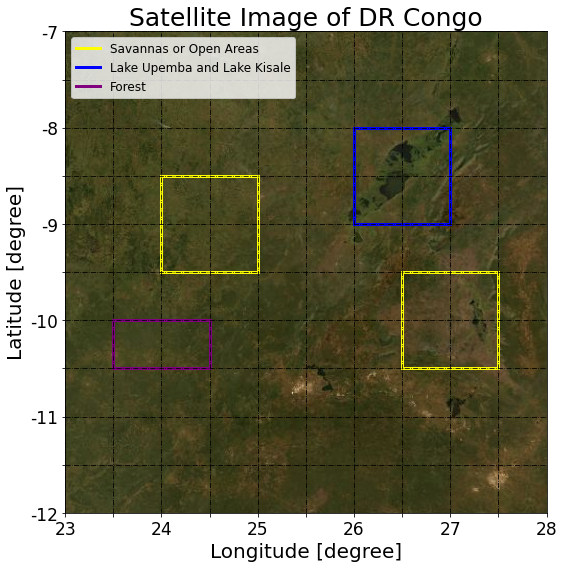

In [259]:
plt.rcParams["figure.autolayout"] = True
im = plt.imread("/Users/vegardhaneberg/Desktop/Time Series/Congo/Areal Congo.png")
fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(im, extent=[23, 28, -12, -7])

plt.title('Satellite Image of DR Congo', fontsize=25)
plt.xlabel('Longitude [degree]', fontsize=20)
plt.ylabel('Latitude [degree]', fontsize=20)

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

ax.xaxis.set_ticks([23, 24, 25, 26, 27, 28])
ax.set_xticklabels(['23', '24', '25', '26', '27', '28'], fontsize=17)
ax.yaxis.set_ticks([-7, -8, -9, -10, -11, -12])
ax.set_yticklabels(['-7', '-8', '-9', '-10', '-11', '-12'], fontsize=17)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))

# plt.yticks([26, 27, 28, 29, 30, 31], fontsize=20)
# plt.xticks([59, 60, 61, 62, 63, 64], fontsize=20)
# plt.yticks([26, 26.5, 27, 27.5, 28, 28.5, 29, 29.5, 30, 30.5, 31], fontsize=20)
# plt.xticks([59, 59.5, 60, 60.5, 61, 61.5, 62, 62.5, 63, 63.5, 64], fontsize=20)

ax.grid(color='black', ls='-.')

# Open Area
ax.add_patch(Rectangle((24, -9.5), 1, 1, lw=3, fill=False, edgecolor='yellow'))
ax.add_patch(Rectangle((26.5, -10.5), 1, 1, lw=3, fill=False, edgecolor='yellow'))

# Lakes
ax.add_patch(Rectangle((26, -9), 1, 1, lw=3, fill=False, edgecolor='blue'))

# Forest Area
ax.add_patch(Rectangle((23.5, -10.5), 1, 0.5, lw=3, fill=False, edgecolor='purple'))

# Legend
legend_elements = [Line2D([0], [0], color='yellow', lw=3, label='Savannas or Open Areas'),
                   Line2D([0], [0], color='blue', lw=3, label='Lake Upemba and Lake Kisale'),
                   Line2D([0], [0], color='purple', lw=3, label='Forest'),]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12)



plt.savefig('/Users/vegardhaneberg/Desktop/Time Series/Congo/Areal Congo Plot')
plt.show()

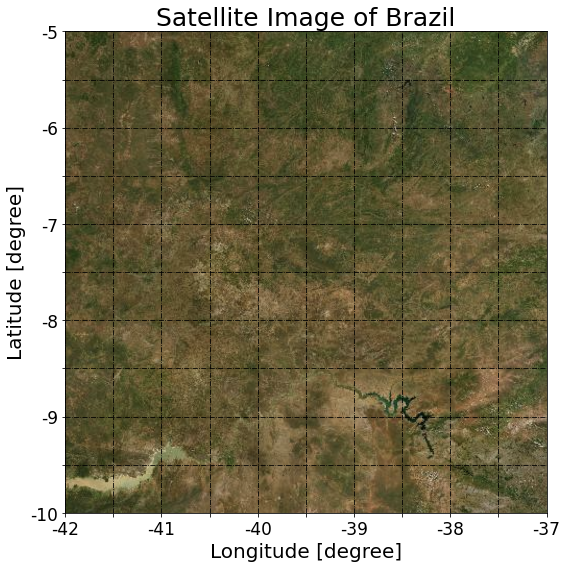

In [247]:
plt.rcParams["figure.autolayout"] = True
im = plt.imread("/Users/vegardhaneberg/Desktop/Time Series/Brazil/Areal Brazil.png")
fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(im, extent=[-42, -37, -10, -5])

plt.title('Satellite Image of Brazil', fontsize=25)
plt.xlabel('Longitude [degree]', fontsize=20)
plt.ylabel('Latitude [degree]', fontsize=20)

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

ax.xaxis.set_ticks([-42, -41, -40, -39, -38, -37])
ax.set_xticklabels(['-42', '-41', '-40', '-39', '-38', '-37'])
ax.yaxis.set_ticks([-10, -9, -8, -7, -6, -5])
ax.set_yticklabels(['-10', '-9', '-8', '-7', '-6', '-5'])

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))

# plt.yticks([26, 27, 28, 29, 30, 31], fontsize=20)
# plt.xticks([59, 60, 61, 62, 63, 64], fontsize=20)
# plt.yticks([26, 26.5, 27, 27.5, 28, 28.5, 29, 29.5, 30, 30.5, 31], fontsize=20)
# plt.xticks([59, 59.5, 60, 60.5, 61, 61.5, 62, 62.5, 63, 63.5, 64], fontsize=20)


# Sobradinho Reservoir
ax.add_patch(Rectangle((59, 27.05), 1.1, 0.65, lw=3, fill=False, edgecolor='blue'))

# Legend
# legend_elements = [Line2D([0], [0], color='blue', lw=3, label='Flooded Area Jan 2020')]
# ax.legend(handles=legend_elements, loc='upper left', fontsize=12)


ax.grid(color='black', ls='-.')
plt.savefig('/Users/vegardhaneberg/Desktop/Time Series/Brazil/Areal Brazil Plot')
plt.show()

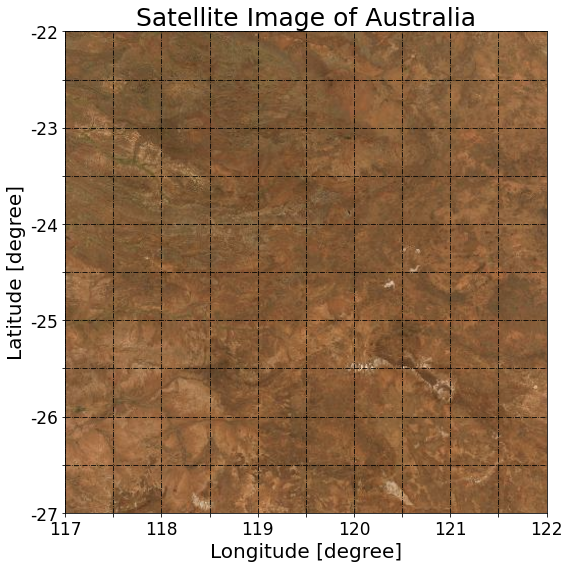

In [268]:
plt.rcParams["figure.autolayout"] = True
im = plt.imread("/Users/vegardhaneberg/Desktop/Time Series/Australia/Areal Australia.png")
fig, ax = plt.subplots(figsize=(8, 8))

im = ax.imshow(im, extent=[117, 122, -27, -22])

plt.title('Satellite Image of Australia', fontsize=25)
plt.xlabel('Longitude [degree]', fontsize=20)
plt.ylabel('Latitude [degree]', fontsize=20)

ax.xaxis.set_ticks([117, 118, 119, 120, 121, 122])
ax.set_xticklabels(['117', '118', '119', '120', '121', '122'], fontsize=17)
ax.yaxis.set_ticks([-27, -26, -25, -24, -23, -22])
ax.set_yticklabels(['-27', '-26', '-25', '-24', '-23', '-22'], fontsize=17)

# plt.yticks([26, 27, 28, 29, 30, 31], fontsize=20)
# plt.xticks([59, 60, 61, 62, 63, 64], fontsize=20)
# plt.yticks([26, 26.5, 27, 27.5, 28, 28.5, 29, 29.5, 30, 30.5, 31], fontsize=20)
# plt.xticks([59, 59.5, 60, 60.5, 61, 61.5, 62, 62.5, 63, 63.5, 64], fontsize=20)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))

# Sobradinho Reservoir
ax.add_patch(Rectangle((59, 27.05), 1.1, 0.65, lw=3, fill=False, edgecolor='blue'))

# Legend
# legend_elements = [Line2D([0], [0], color='blue', lw=3, label='Flooded Area Jan 2020')]
# ax.legend(handles=legend_elements, loc='upper left', fontsize=12)


ax.grid(color='black', ls='-.')
plt.savefig('/Users/vegardhaneberg/Desktop/Time Series/Australia/Areal Australia Plot')
plt.show()